# Milestone 2

### Rob Lisy

Generate a clear statement problem and provide location for dataset.
Provide a clear solution to the problem for a non-technical audience. Your solution must include narrative in plain language explaining your results. 

Visually explore the data to generate insight and include summary statistics. For your visualization use multiple views of the data, which can include:
- scatter plots showing key relationships you have found in the dataset. Beware of over-plotting. 
- bar, box or violin plots for various categorical groups within the dataset. 
- Faceted plots to show diffences for different groups with in the data. 
- Other plot types you find useful; heatmaps, histograms, etc. 
- All plots should use methods that will aid in viewer perception. 

----

#### Additional Steps:

In Milestone 1 I did lots of code (I'll note the transition point below). I've got to add the following additional steps for Milestone 2:

- Identify a likely distribution for several of the features
- Compute basic summary statistics by both classical, bootstrap, and Bayesian methods;
- Compute confidence intervals for the above summary statistics by classical, bootstrap, and Bayesian methods;
- Leverage confidence intervals in performing hypothesis tests to determine if the differences in pairs and multiple populations are significant.


----------
Problem statement:
    A young family moving to King county would like to know how housing features contribute to the price of different houses. This may help them focus their search on houses within their price range.
    
Data sets: 
    Housing price data for King County - https://www.kaggle.com/harlfoxem/housesalesprediction
    Neighborhood boundaries and labels - https://data.opendatasoft.com/explore/dataset/zillow-neighborhoods%40public/information/

In [1]:
from os import path
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from zipfile import ZipFile
import scipy
import statsmodels.stats.api as sms

# Pretty printing
%precision %.2f
pd.set_option('display.float_format', lambda x: '%.5f' % x)
plt.rcParams["figure.figsize"] = (20,10)

housing_data = f"kc_house_data.csv"


def download_if_not_exists(URL: str, filename: str):
    """
    Helper function to download the file at the URL if it doesn't already exist
    :param URL: A string with the URL location
    :param filename: The file name on disk
    """
    if path.exists(f"{filename}"):
        return
    else:
        req = requests.get(URL)
        url_content = req.content
        csv_file = open(f"{filename}", 'wb')
        csv_file.write(url_content)
        csv_file.close()
    return

# Download our source data if we don't have it locally...
download_if_not_exists("https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/kc_house_data.csv",
                      housing_data)
# This is the Zillow shape files for neighborhoods.
#download_if_not_exists("https://data.opendatasoft.com/explore/dataset/zillow-neighborhoods@public/download/?format=shp&refine.state=WA&refine.county=King&timezone=America/Los_Angeles",
#                      neighborhoods)

#unzip the shape file from Zillow
#with ZipFile(neighborhoods, 'r') as zip: 
#    zip.extractall()

# import the CSVs as a data set
housing = pd.read_csv(housing_data, header=0)
housing.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.00000,3,1.00000,1180,5650,1.00000,0,0,...,7,1180,0,1955,0,98178,47.51120,-122.25700,1340,5650
1,6414100192,20141209T000000,538000.00000,3,2.25000,2570,7242,2.00000,0,0,...,7,2170,400,1951,1991,98125,47.72100,-122.31900,1690,7639
2,5631500400,20150225T000000,180000.00000,2,1.00000,770,10000,1.00000,0,0,...,6,770,0,1933,0,98028,47.73790,-122.23300,2720,8062
3,2487200875,20141209T000000,604000.00000,4,3.00000,1960,5000,1.00000,0,0,...,7,1050,910,1965,0,98136,47.52080,-122.39300,1360,5000
4,1954400510,20150218T000000,510000.00000,3,2.00000,1680,8080,1.00000,0,0,...,8,1680,0,1987,0,98074,47.61680,-122.04500,1800,7503


In [2]:
# see what the column types are, and clean them up
housing.dtypes

cat_cols = ['waterfront', 'view','condition','zipcode', 'grade']
for c in cat_cols:
    housing[c] = housing[c].astype('category')

housing['date'] = pd.to_datetime(housing['date'], errors='coerce')

In [3]:
housing.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront             category
view                   category
condition              category
grade                  category
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                category
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

In [4]:
# Let's describe the summary statistics
# Housing data is always SUPER skewed... we're going to generate some custom percentiles for the .describe()
housing.describe(percentiles=[x/10 for x in range(1,10)]+[.95, .99, .995])

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000
mean,4580301520.86499,540088.14177,3.37084,2.11476,2079.89974,15106.96757,1.49431,1788.39069,291.50905,1971.00514,84.40226,47.56005,-122.21390,1986.55249,12768.45565
std,2876565571.31206,367127.19648,0.93006,0.77016,918.44090,41420.51152,0.53999,828.09098,442.57504,29.37341,401.67924,0.13856,0.14083,685.39130,27304.17963
min,1000102.00000,75000.00000,0.00000,0.00000,290.00000,520.00000,1.00000,290.00000,0.00000,1900.00000,0.00000,47.15590,-122.51900,399.00000,651.00000
10%,1036000346.00000,245000.00000,2.00000,1.00000,1090.00000,3322.20000,1.00000,970.00000,0.00000,1926.00000,0.00000,47.35030,-122.37200,1256.00000,3666.60000
20%,1774000252.00000,298470.00000,3.00000,1.50000,1320.00000,4644.00000,1.00000,1120.00000,0.00000,1947.00000,0.00000,47.43224,-122.34600,1420.00000,4800.00000
30%,2517000630.00000,345000.00000,3.00000,1.75000,1520.00000,5612.00000,1.00000,1260.00000,0.00000,1956.00000,0.00000,47.49690,-122.31200,1550.00000,5625.60000
40%,3278601732.00000,399500.00000,3.00000,2.00000,1710.00000,6744.00000,1.00000,1400.00000,0.00000,1965.00000,0.00000,47.53960,-122.28700,1690.00000,6750.00000
50%,3904930410.00000,450000.00000,3.00000,2.25000,1910.00000,7618.00000,1.50000,1560.00000,0.00000,1975.00000,0.00000,47.57180,-122.23000,1840.00000,7620.00000
60%,5307500252.00000,519000.00000,4.00000,2.50000,2130.00000,8520.20000,2.00000,1760.00000,0.00000,1983.00000,0.00000,47.62110,-122.18900,2020.00000,8382.00000


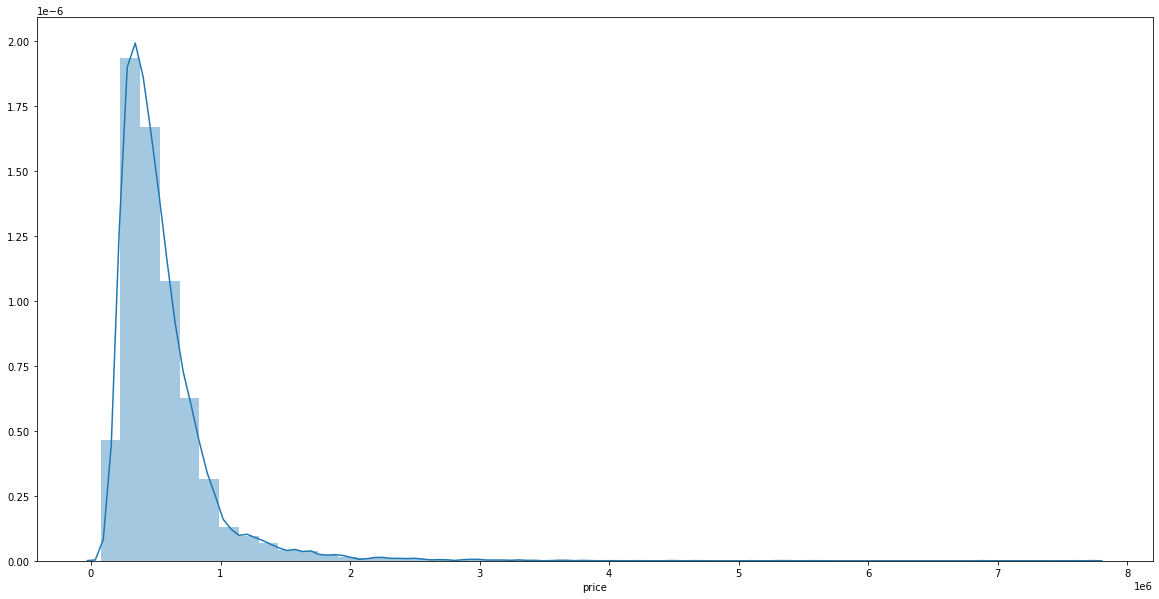

In [5]:
# Graph the price
sns.distplot(housing['price']);

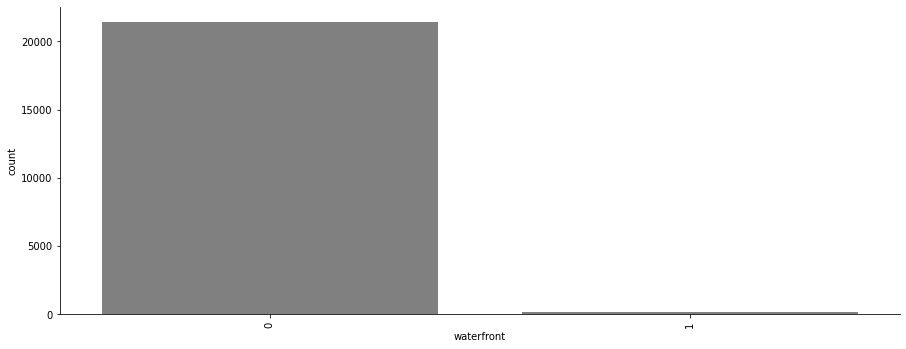

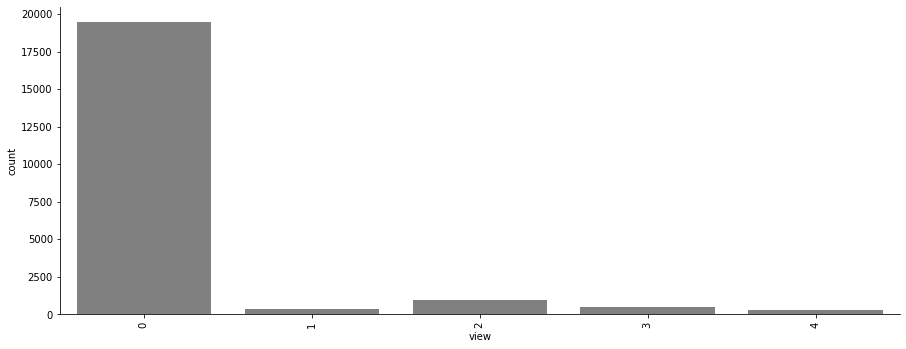

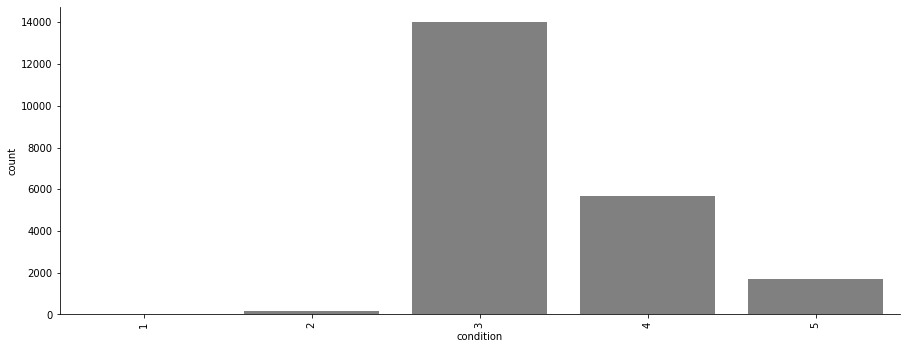

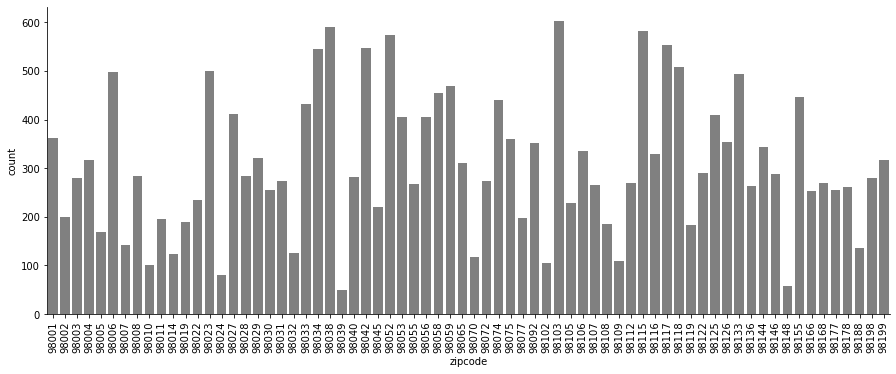

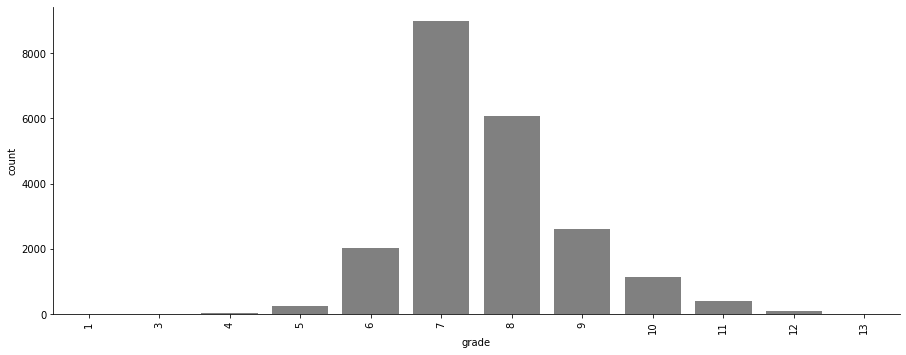

In [6]:
# Plot some densities using bar graphs
cat_cols = ['waterfront', 'view', 'condition', 'zipcode', 'grade']

for c in cat_cols:
    g = sns.catplot(x = c, data = housing, kind = 'count', color = 'grey', aspect = 2.5);
    g.set_xticklabels(rotation = 90);
    plt.show()

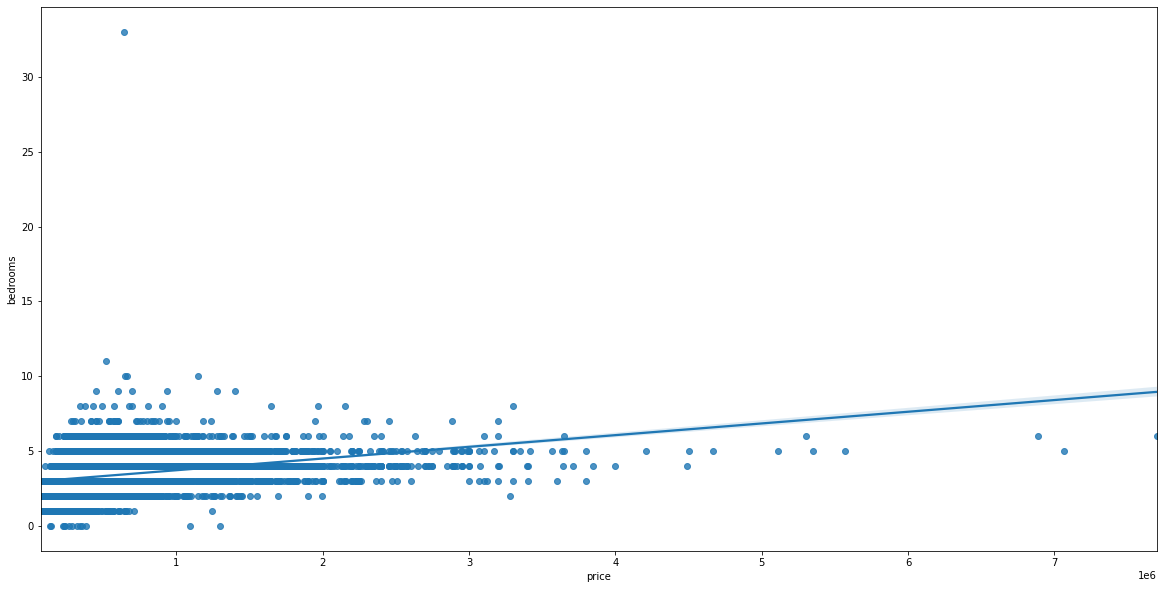

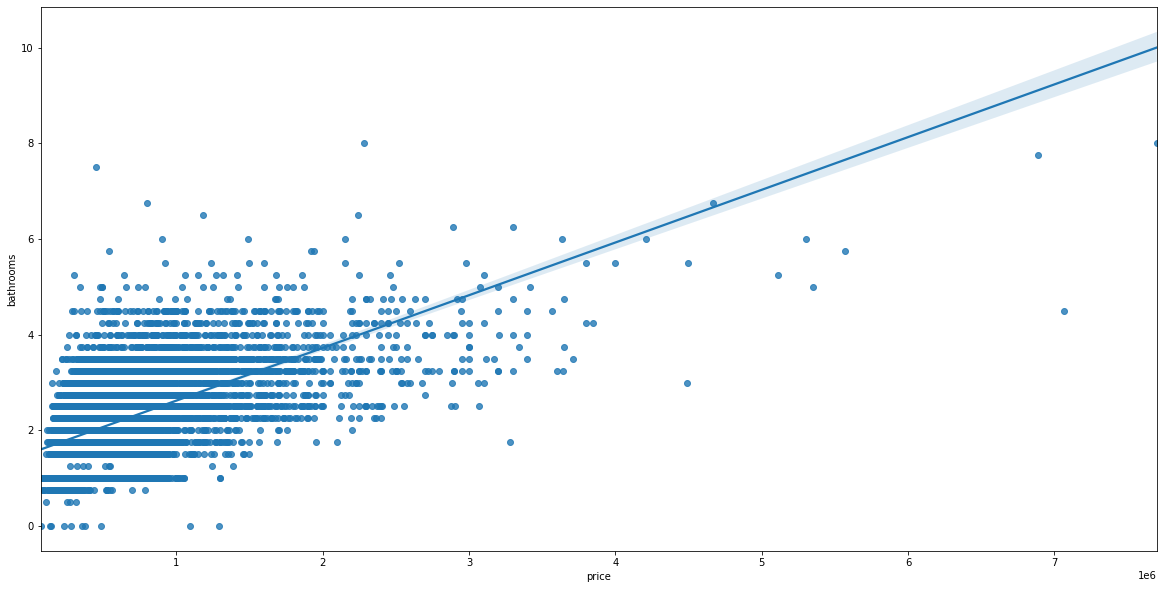

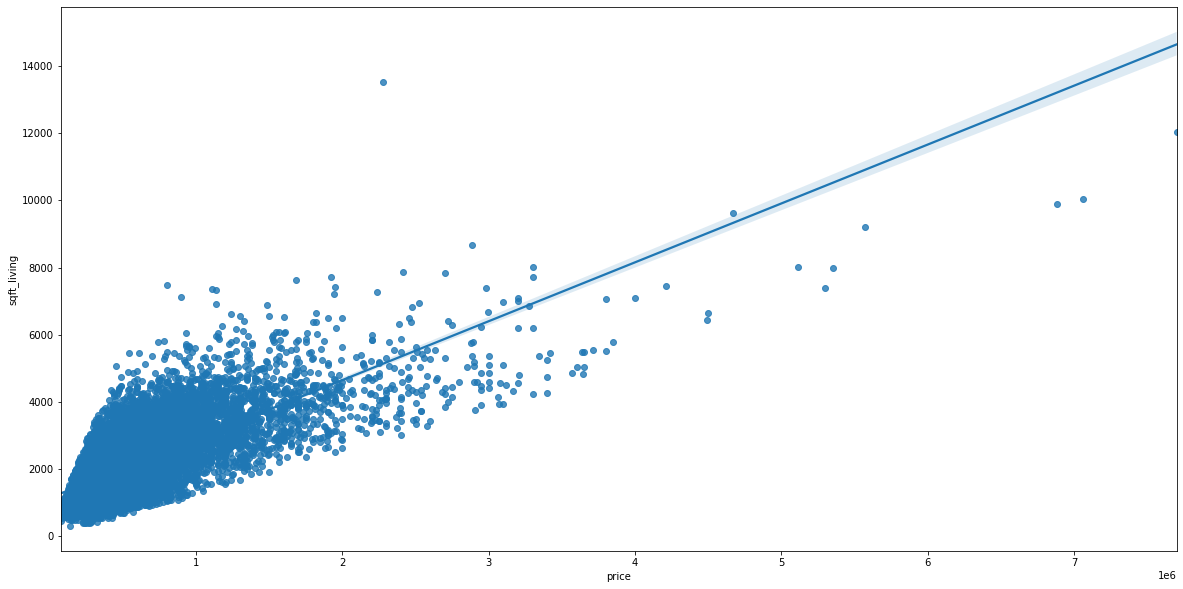

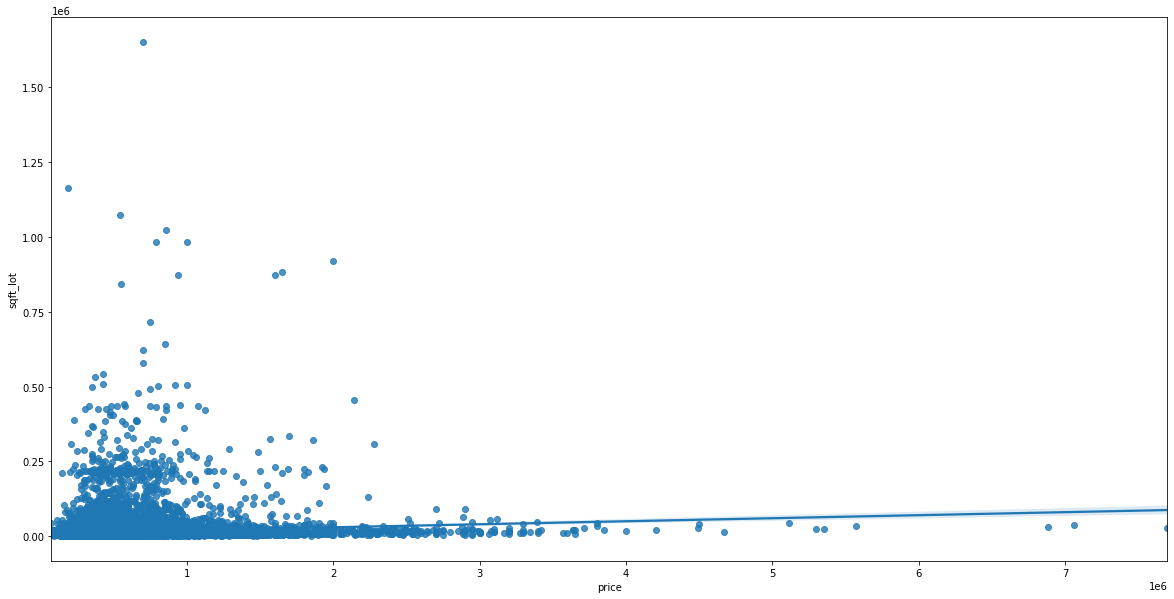

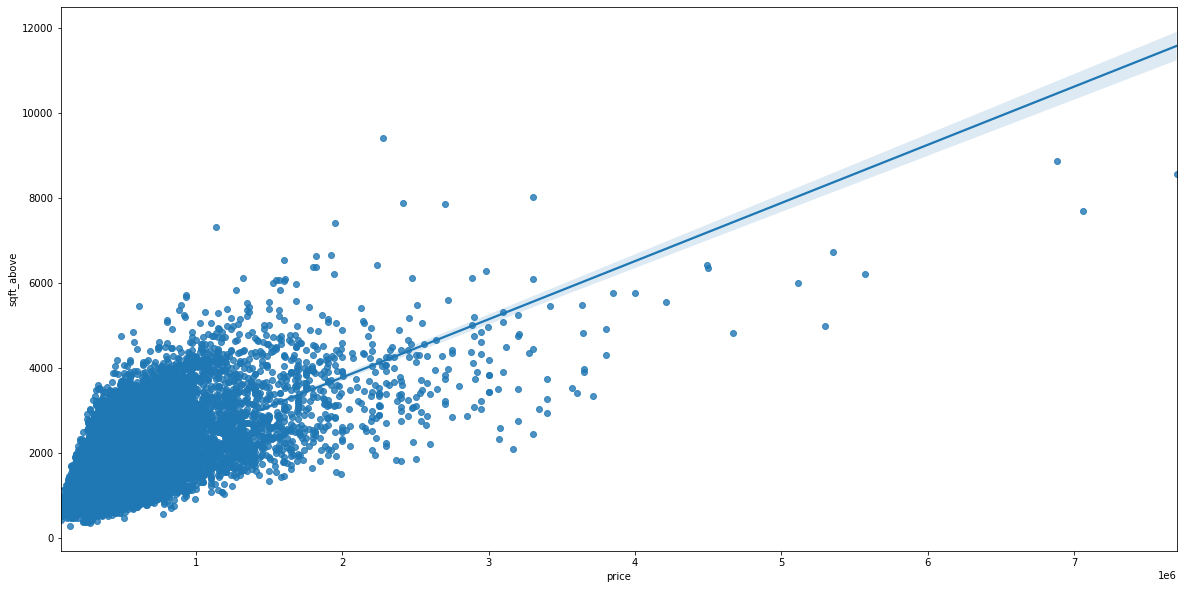

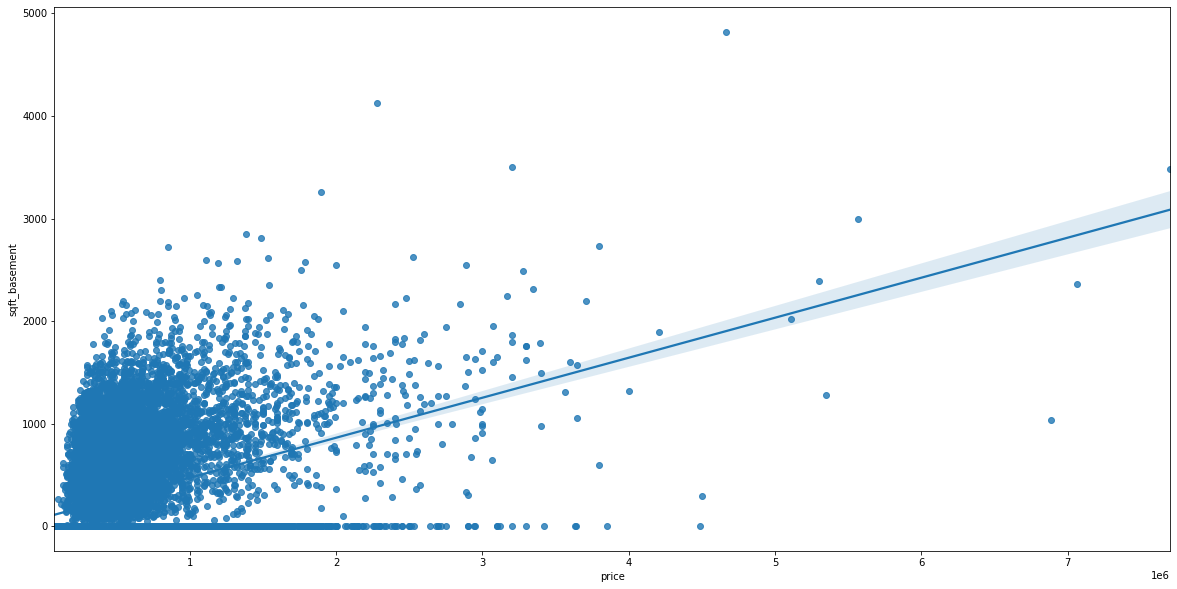

In [7]:
# This is going to be a regression model, since price is continuous. Let's plot relationships between some variables and price.
price_rel_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in price_rel_cols:
    sns.regplot(housing['price'], housing[c])
    plt.show();

# Looks like we can skip being super concerned with `sqft_lot`

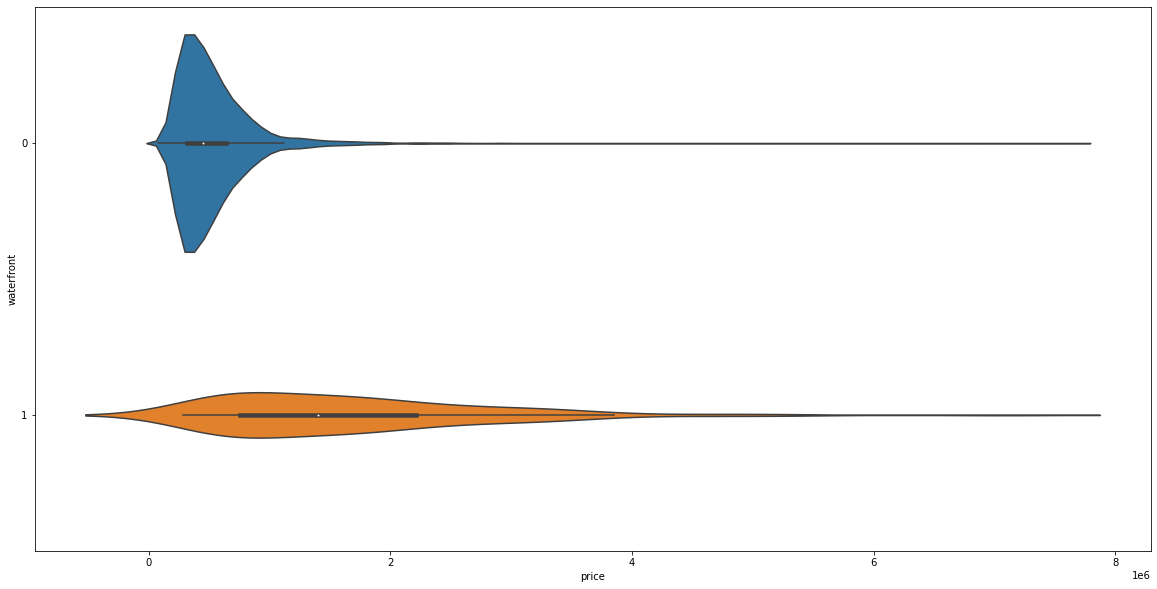

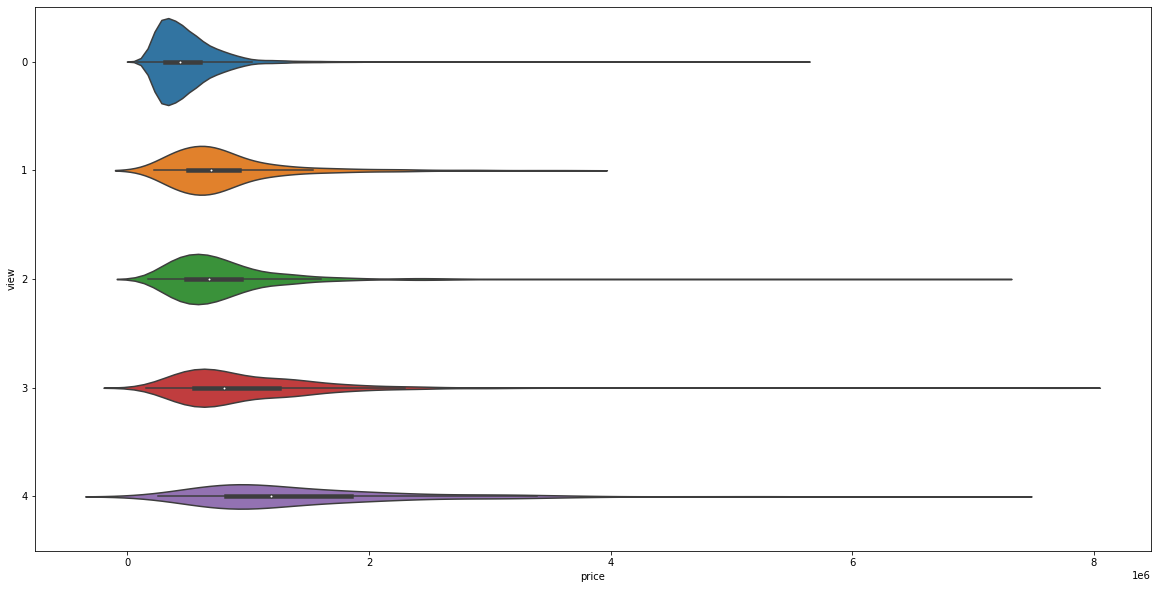

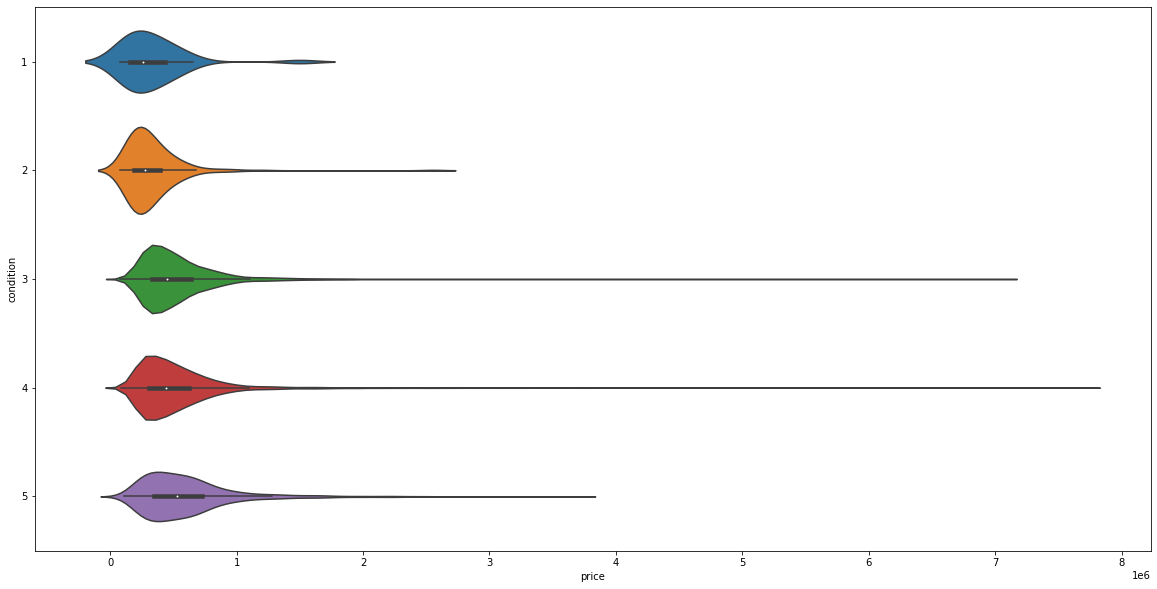

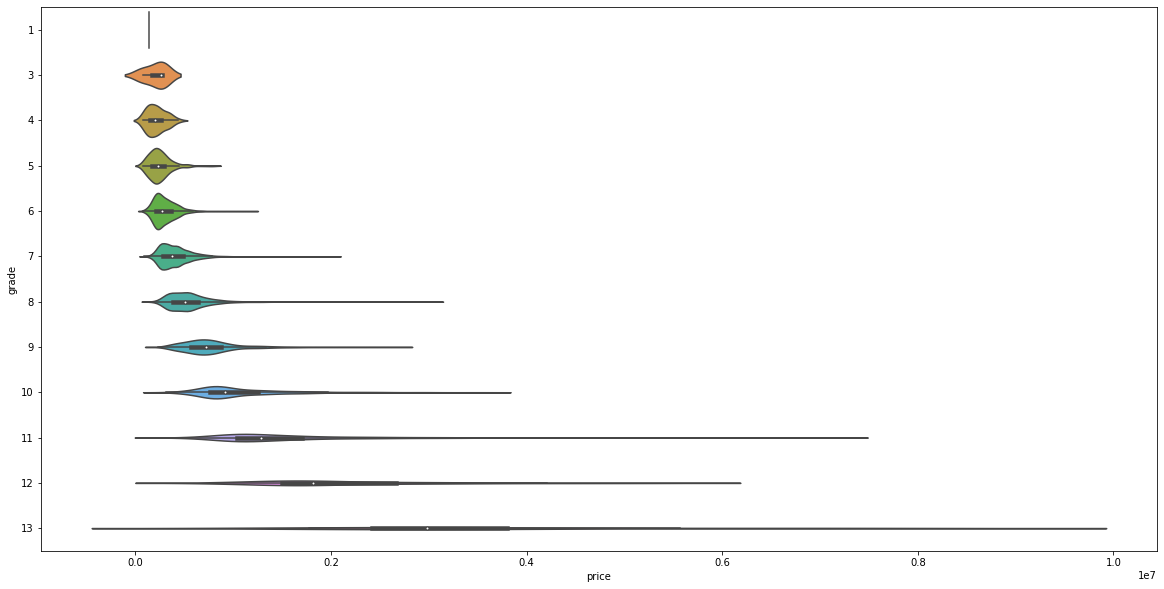

In [8]:
# for the categorical columns, make distribution plots
cat_cols = ['waterfront', 'view', 'condition', 'grade']
for c in cat_cols:
    sns.violinplot(x=housing['price'], y=housing[c])
    plt.show();

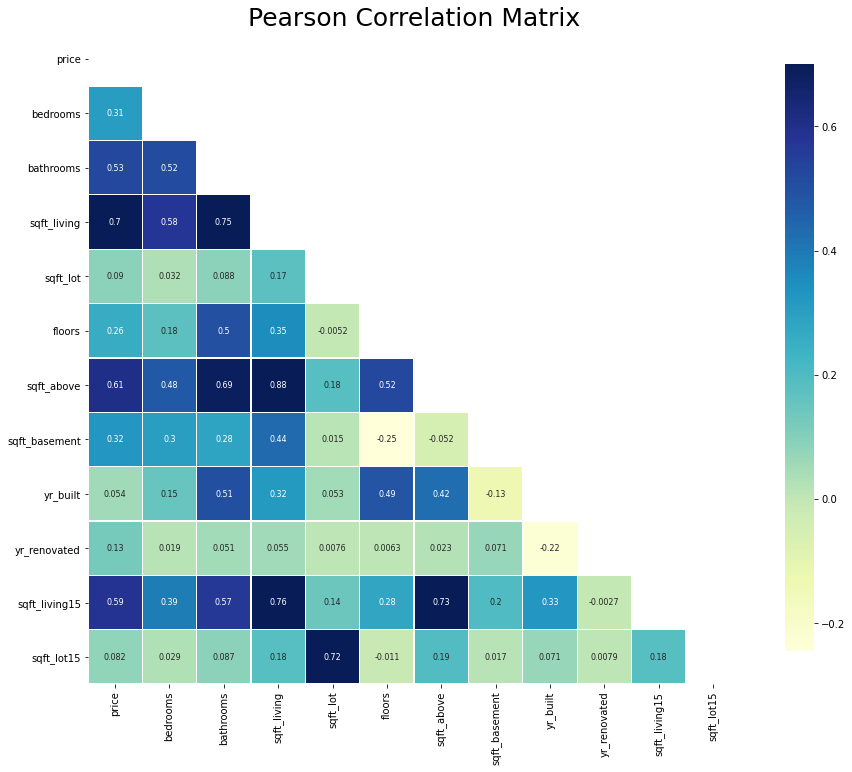

In [9]:
# Let's make a heat map for the correlations
features = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront',
            'view','condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated',
            'sqft_living15','sqft_lot15']

# Remove columns without correlation OR boolean values
mask = np.zeros_like(housing[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix', fontsize=25)

sns.heatmap(housing[features].corr(), linewidths=0.25, vmax=0.7, square=True, cmap="YlGnBu",
            linecolor='w', annot=True, annot_kws={"size":8}, mask=mask, cbar_kws={"shrink": .9});

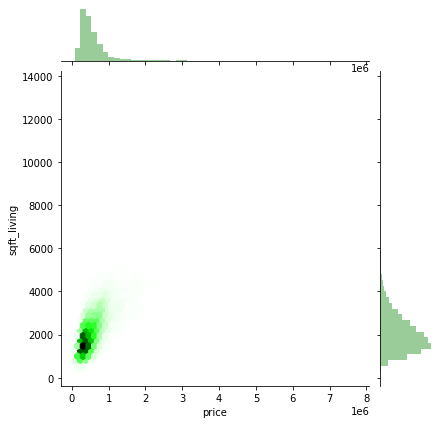

In [10]:
# Hexbin between price and square footage
sns.jointplot(x = 'price', y = 'sqft_living', data = housing, kind = 'hex', color = 'green');

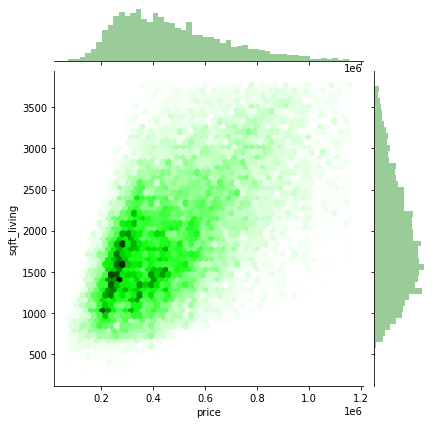

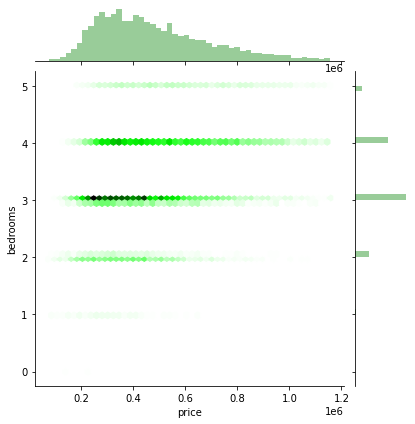

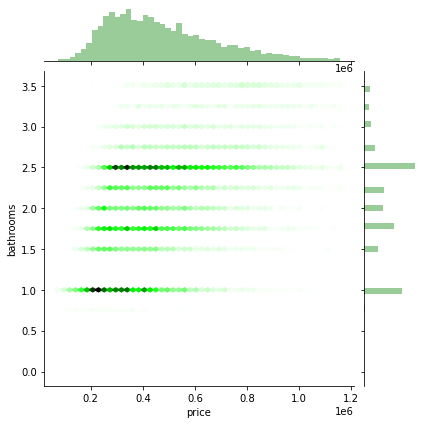

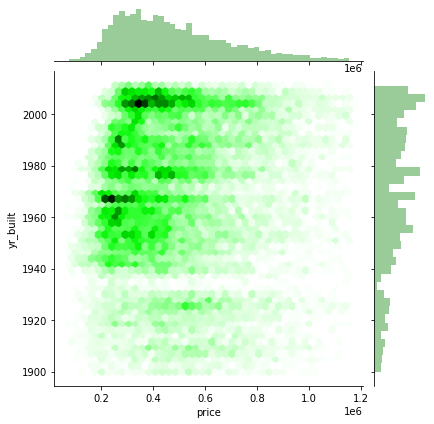

In [11]:
# Looks like this is highly sensitive to outliers (14,000 sq ft house? $7.7m sale price?)
# Let's limit the plot axis so that we're not only seeing those values
# these limits are at the 95% levels, per the .describe() above.
c_price = housing['price'] <= 1156480

cols_conditions = [['sqft_living', (housing['sqft_living'] <= 3760)],
                   ['bedrooms', (housing['bedrooms'] <= 5)],
                   ['bathrooms', (housing['bathrooms'] <= 3.5)],
                   ['yr_built', (housing['yr_built'] <= 2011)]
                  ]
# for every column and filter combo, make a pretty hex bin graph
for c in cols_conditions:
    plot_data = housing[c[1] & c_price]
    sns.jointplot(x = 'price', y = c[0], data = plot_data, kind = 'hex', color = 'green');

# Summary

Our couple who is looking to find a home would do well to keep the total square footage of the property in mind. 

If they want to be conscious of their budget, they should look for: 
- something built in the late 1960s (vs a bunch of the newer houses post 2000 that are higher in price)
- there's lots of variation (and therefore choice) in houses with 2.5 bathrooms
- they'll probably look for a 3 bedroom house

----
## Milestone 2

The below work is added for Milestone 2


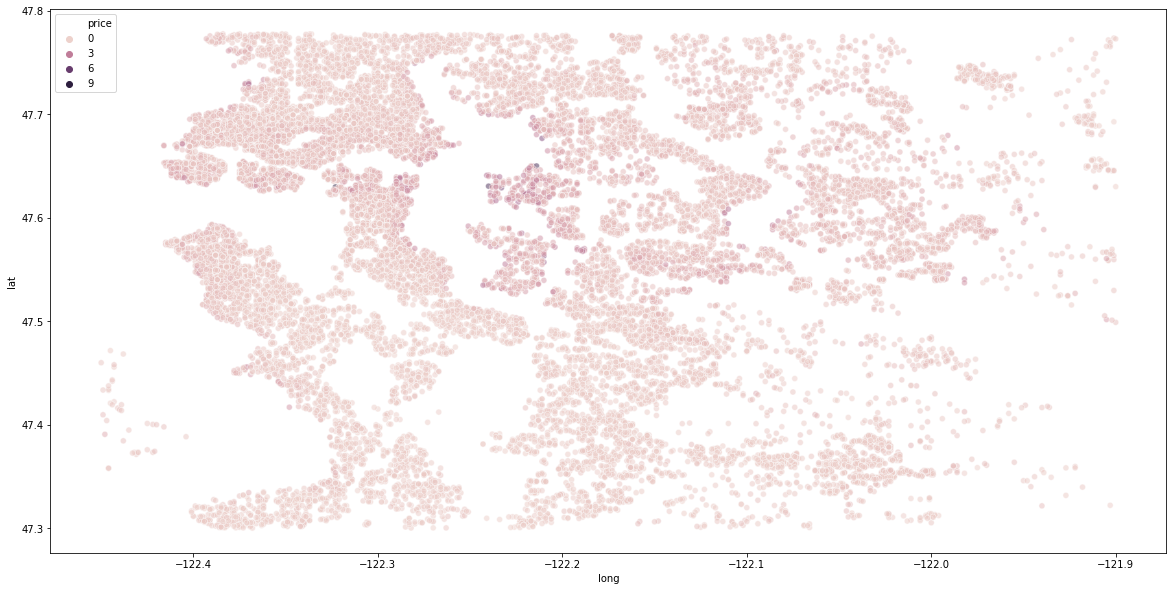

In [12]:
# Let's make a "map"
# kind of silly, but we can show the neighborhood effect

# there's a bunch of stuff in like Woodenville... not showing it for this viz
is_east = housing['long'] <= -121.9
is_west = housing['long'] >= -122.45
is_south = housing['lat'] >= 47.3
housing_zoom = housing[is_east & is_west & is_south]

sns.scatterplot(x = housing_zoom['long'], y = housing_zoom['lat'], 
               hue = housing_zoom['price'],
               alpha = .5);

## Location, location, location.
You can pretty clearly see the neighborhoods and geography of Seattle:
- Belleview, Mercer Island, Capitol Hill all have some high prices.
- There are no homes sold in the ocean, SeaTac airport, the industrial south, or the core of the city.

For simplicity sake, I didn't plot Vashon Island (mostly), or the stuff that's pretty far east of Settle metro.

In [13]:
housing.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront             category
view                   category
condition              category
grade                  category
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                category
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

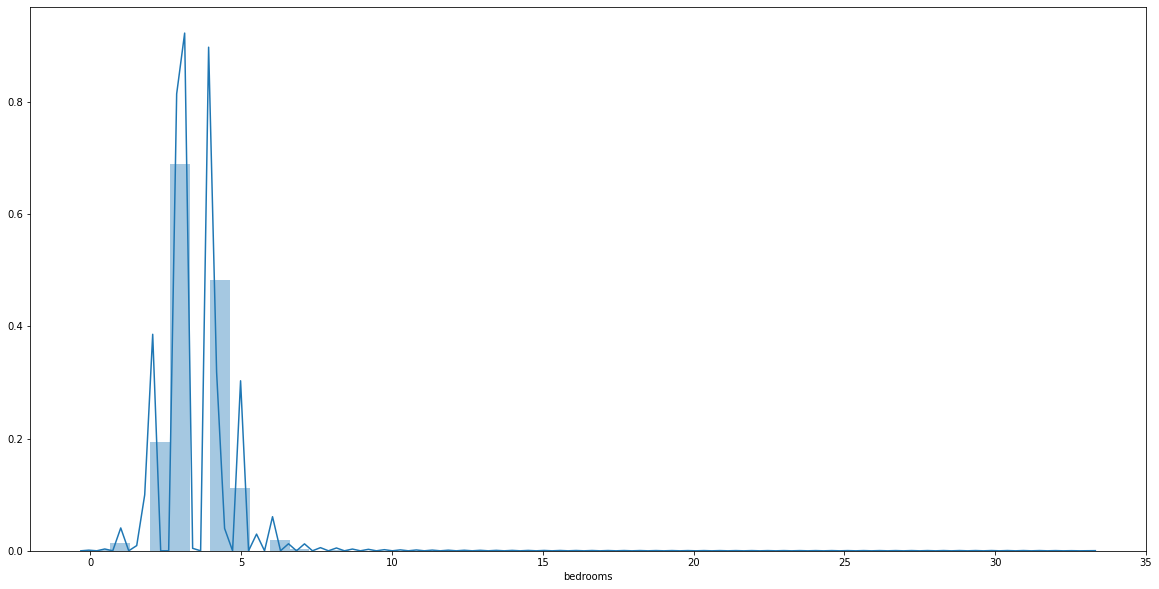

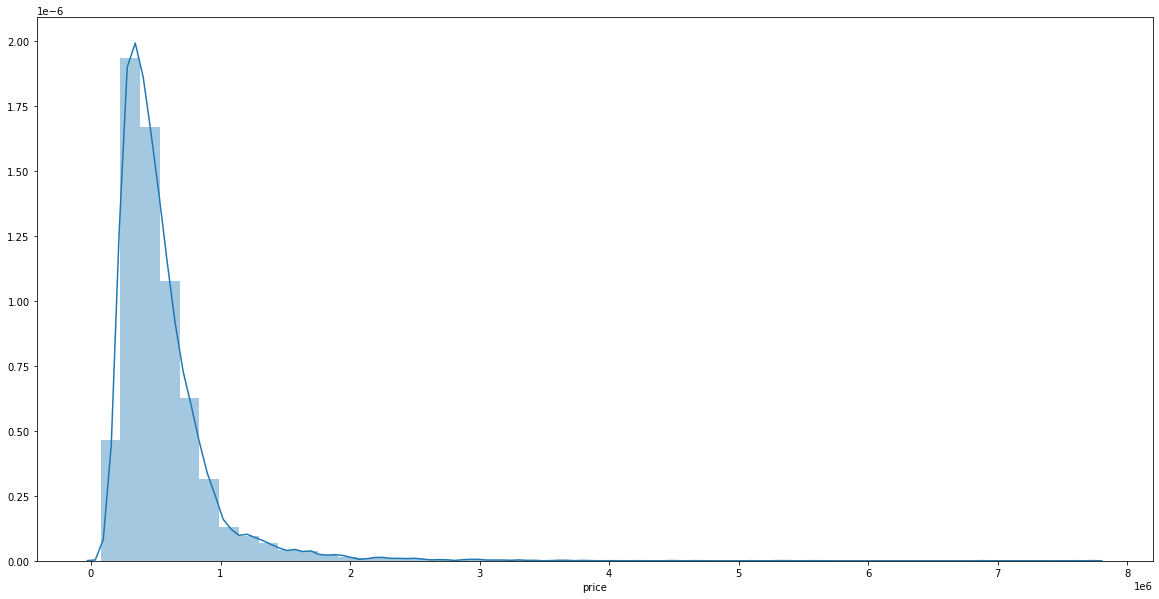

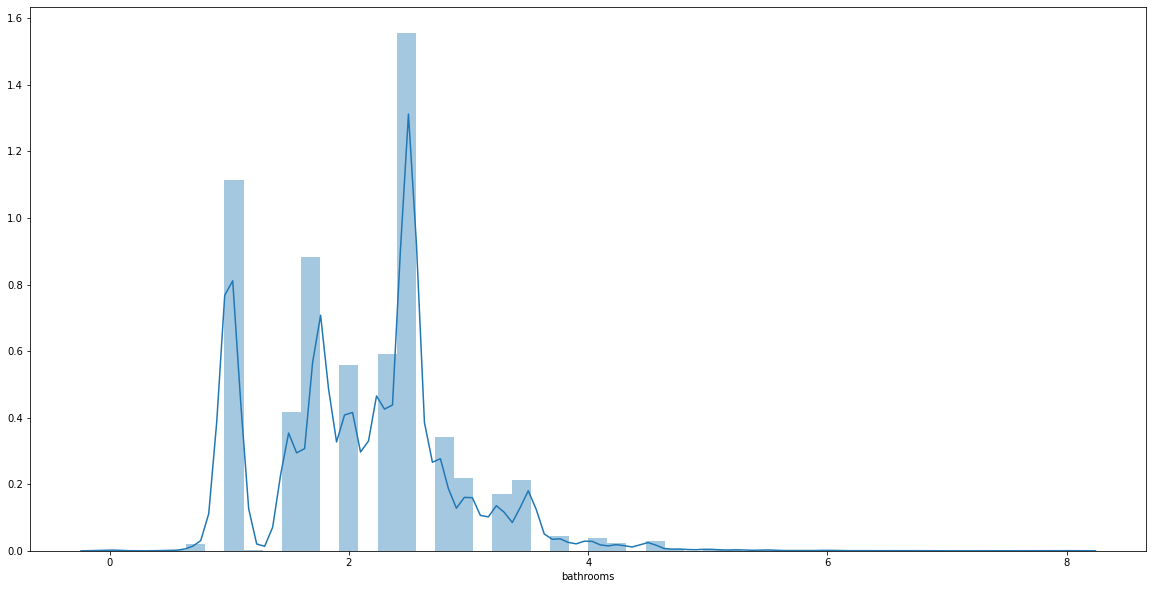

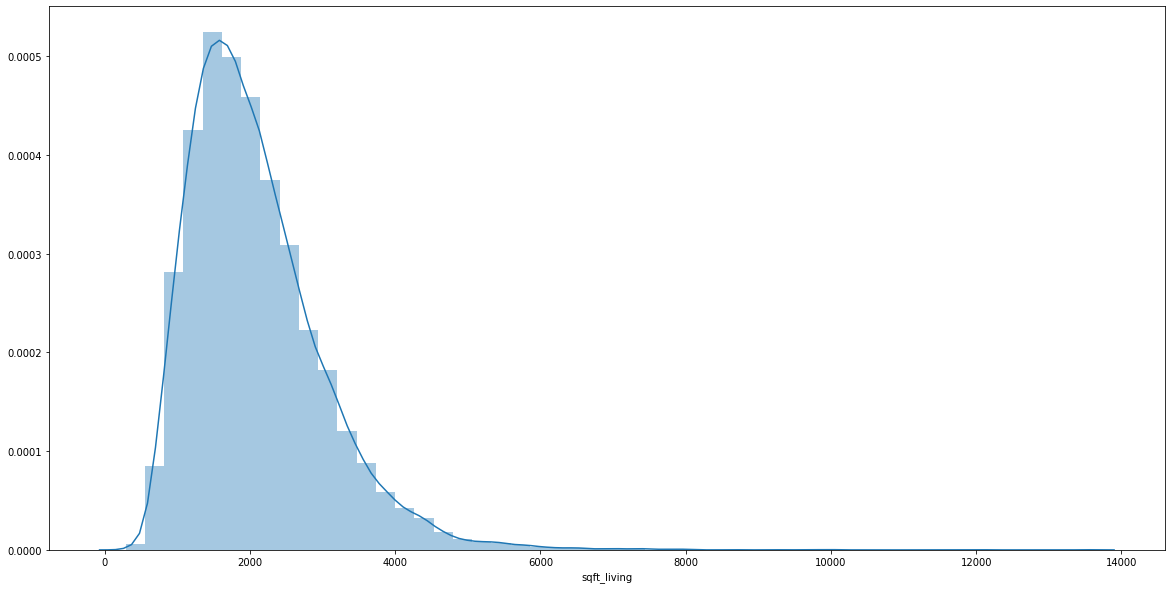

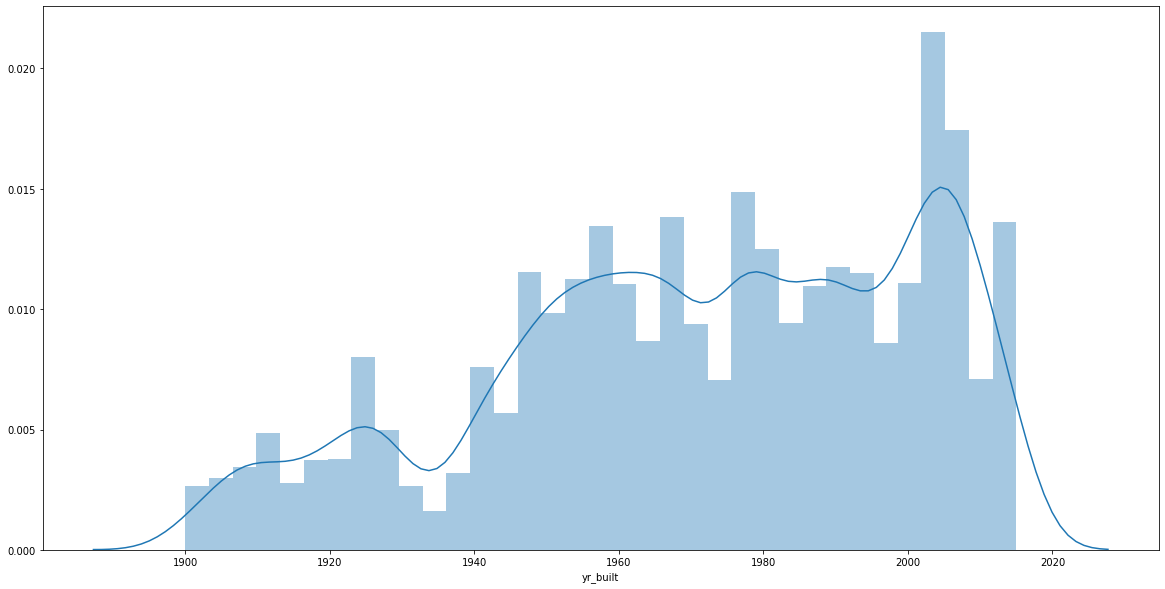

In [14]:
# Time to get into it
# - Identify a likely distribution for several of the features
plot_cols = ['bedrooms', 'price', 'bathrooms', 'sqft_living', 'yr_built']

for c in plot_cols:
    sns.distplot(housing[c])
    plt.show()


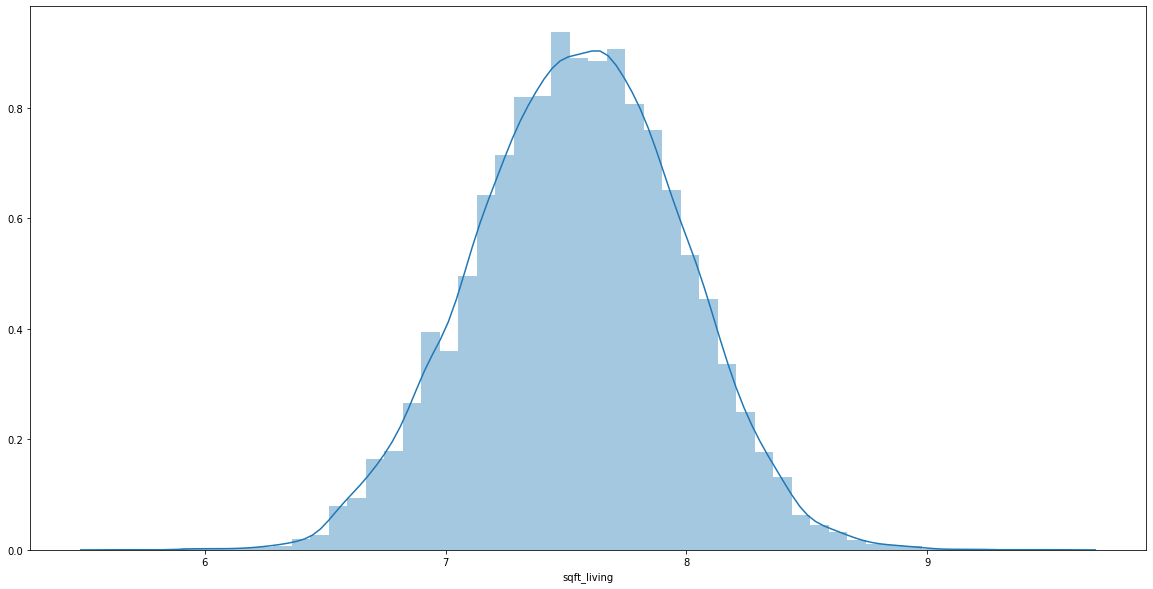

In [15]:
# Lets test some distributions!
# I think sqft_living is normal
sns.distplot(np.log(housing['sqft_living']));

# yeah, that's log normal.

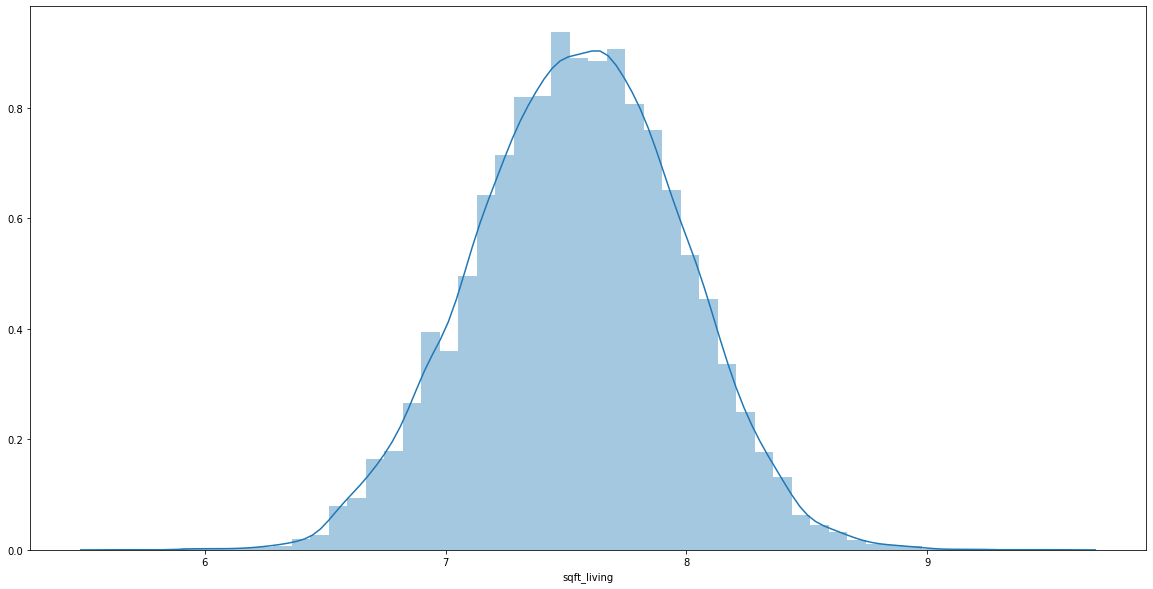

In [16]:
# How about price?
sns.distplot(np.log(housing['sqft_living']));

# also stupidly log normal.

# I'm adding a transformed column... hate messing with the np.log() stuff
housing['log_price'] = np.log(housing['price'])
housing['log_sqft_living'] = np.log(housing['sqft_living'])

### Compute basic summary statistics by both classical, bootstrap, and Bayesian methods

In [17]:
# Classical
print(f"Classical mean for price is {housing['price'].mean()}")

Classical mean for price is 540088.1417665294


Confidence interval using bootstrapping for price is between 539699.8320507604 and 540009.3734790593


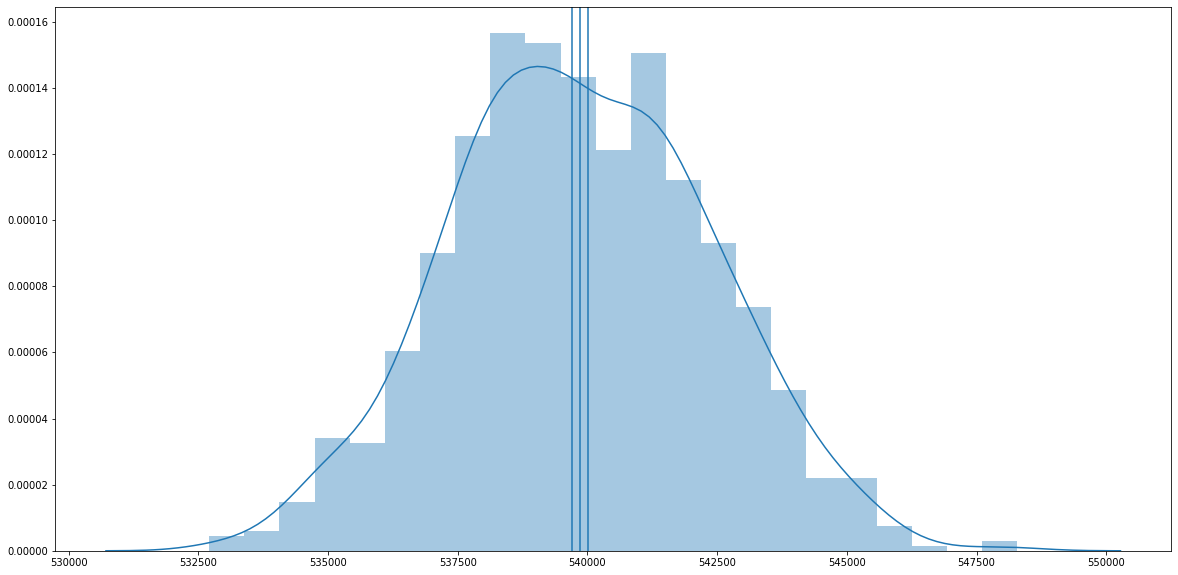

In [18]:
# Bootstrap
n_samples = 1000

# add in a nice plotting function with mean line
def plot_dist_mean(a, a_label):
    sns.distplot(a, label=a_label)
    plt.axvline(x=a.mean(), ymin=0, ymax=1)

bootstrap_means = pd.Series([    
    housing.sample(frac=1, replace=True)['price'].mean()
    for i in range(n_samples)])

bootstrap_ci_5, bootstrap_ci_95 = sms.DescrStatsW(bootstrap_means).tconfint_mean()

plot_dist_mean(bootstrap_means, 'Bootstrapped Mean with 5 and 95% CI');
plt.axvline(x=bootstrap_ci_5, ymin=0, ymax=1)
plt.axvline(x=bootstrap_ci_95, ymin=0, ymax=1)
print(f"Confidence interval using bootstrapping for price is between {bootstrap_ci_5} and {bootstrap_ci_95}")

In [21]:
price_df = housing['price']
price_df.describe(percentiles=[x/10 for x in range(1,10)]+[.95, .99, .995])

count     21613.00000
mean     540088.14177
std      367127.19648
min       75000.00000
10%      245000.00000
20%      298470.00000
30%      345000.00000
40%      399500.00000
50%      450000.00000
60%      519000.00000
70%      595000.00000
80%      700108.00000
90%      887000.00000
95%     1156480.00000
99%     1964400.00000
99.5%   2453290.00000
max     7700000.00000
Name: price, dtype: float64

In [45]:
# Bayesian
N = 10000
# We're going to use the 10th and 95 percentiles... outliers will mess with this.
x = np.linspace(start = 245000,
                stop = 1156480,
                num = N)

/Users/roblisy/.pyenv/versions/3.7.0/envs/uw_data_sci/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


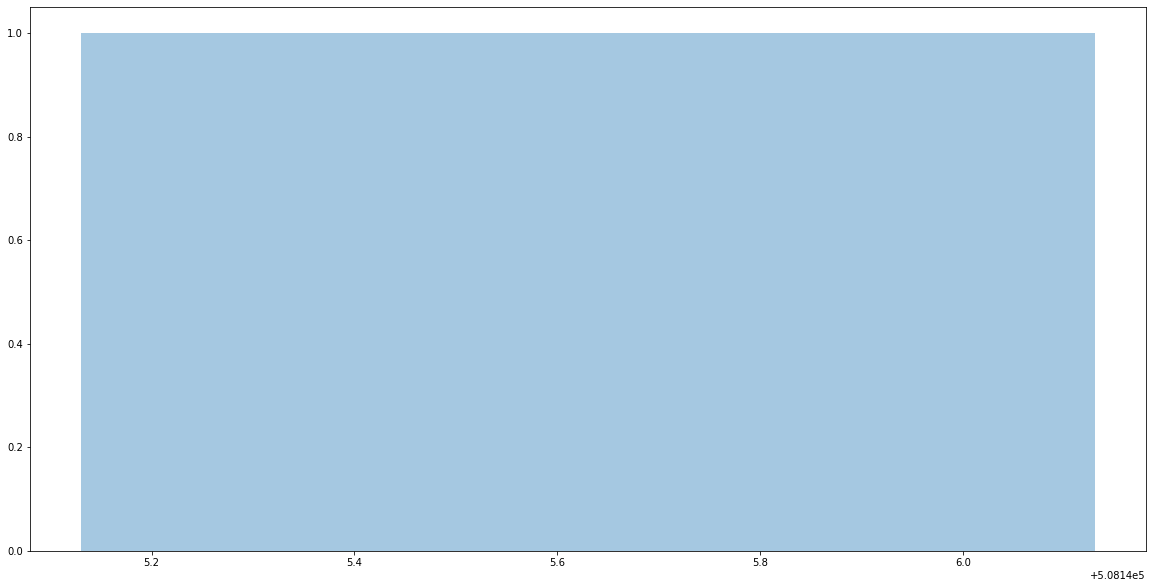

In [46]:
# I want to use a reasonably informed prior, so I'm chosing the 40% and 60% percentile
# This is to say that I believe the true population mean lies somewhere between the 40th and 60th percentile of the King county data set.
prior_price = np.random.uniform(low = housing['price'].quantile(.40), 
                                high = housing['price'].quantile(.60))

sns.distplot(prior_price);

In [65]:
# Now create a posterior estimate of the mean
price_sample = housing.sample(n=n_samples, replace=True)

def likelihood(p, x): 
    x_var = np.var(x) # sigmasqr
    x_mean = np.mean(x)  # xbar
    print(f'Bayesian mean = {x_mean:.3f}, standard deviation = {x_var:.3f}')
    n = len(x)
    l = np.exp((-1/(2*x_var)) * (sum((x - x_mean)**2) + n*(x_mean - p)**2))
    return l / l.sum()

def posterior(prior, like):
    post = prior * like # compute the product of the probabilities
    return post / post.sum() # normalize the distribution to sum to unity

likelihood_price = likelihood(x, price_sample['price'])
posterior_price = posterior(prior_price, likelihood_price)

Bayesian mean = 518983.442, standard deviation = 89420039741.221


10000

The  95% credible interval is 519016.011 to 571071.282


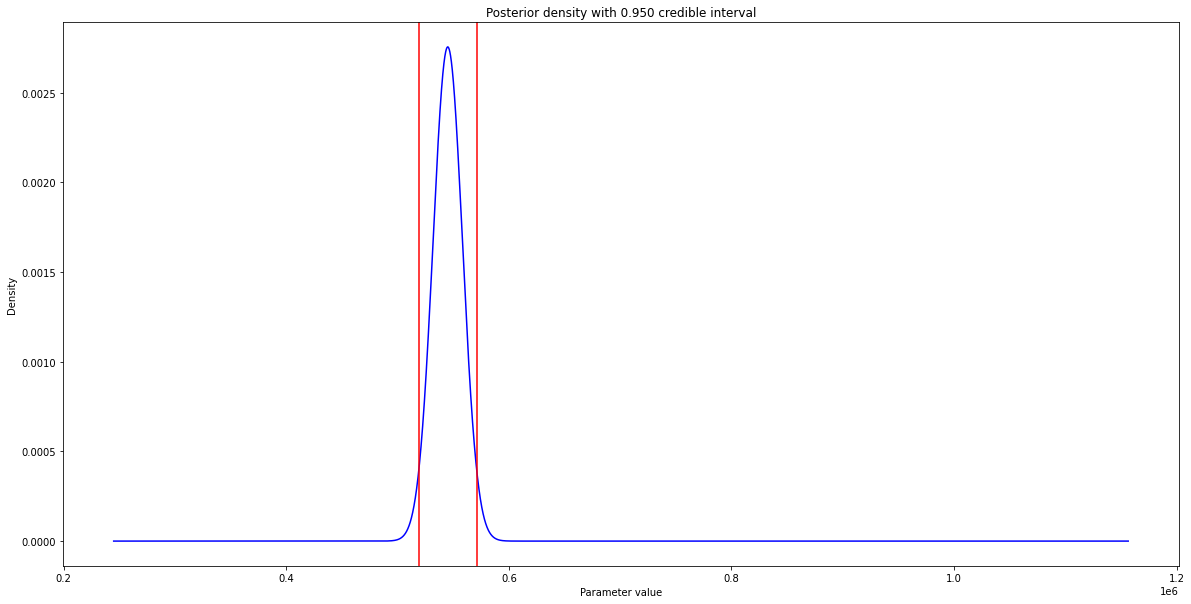

In [64]:
# let's plot the credible interval for the mean estimate
lower_q, upper_q = [.025, .975]

def plot_ci(p, post, num_samples, lower_q, upper_q, **kw):
    ## This function computes a credible interval using an assumption
    ## of symetry in the bulk of the distribution to keep the 
    ## calculation simple. 
    ## Compute a large sample by resampling with replacement
    samples = np.random.choice(p, size = num_samples, replace = True, p = post)
    ci = np.percentile(samples, [lower_q*100, upper_q*100]) # compute the quantiles
    
    interval = upper_q - lower_q
    plt.title('Posterior density with %.3f credible interval' % interval)
    sns.lineplot(p, post, color = 'blue', **kw)
    plt.xlabel('Parameter value')
    plt.ylabel('Density')
    plt.axvline(x = ci[0], color = 'red')
    plt.axvline(x = ci[1], color = 'red')
    print(f'The {interval*100: 0.0f}% credible interval is {ci[0]:0.3f} to {ci[1]:0.3f}')
    
plot_ci(x, posterior_price, N, lower_q, upper_q)

In [66]:
# Leverage confidence intervals in performing hypothesis tests to determine if the differences in pairs and multiple populations are significant.
from scipy.stats import ttest_ind

classical_mean = housing['price'].mean()
bootstrap_mean = bootstrap_means.mean()

ttest, pval = ttest_ind(bootstrap_means, posterior_price)
print("p-value", pval)

p-value 0.0
